# Test of Reservoir Computer prediction of Lorenz '63 System

First, import necessary modules

In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as sparse
from scipy.stats import pearsonr
from scipy.sparse import linalg
from scipy.linalg import solve, pinv
from sklearn import preprocessing
import matplotlib.pyplot as plt

## Define necessary  functions

In [2]:
def dxdt_lorenz(x,time,r_t, sigma = 10., beta = 8/3, rho = 28.):
    # Evaluates derivative of Lorenz '63 system with a time-dependent
    # rho value. For constant rho, input the r_t_const function.
    return np.array([sigma*(- x[0] + x[1]),\
                     r_t(time)*rho*x[0] - x[1] - x[0]*x[2],\
                     x[0]*x[1]-beta*x[2]])
    
def rk4(x, time, tau, r_t, dxdt):
    # Fourth order Runge-Kutta integrator
    
    k1 = dxdt(x, time, r_t)
    k2 = dxdt(x + k1/2*tau, time + tau/2, r_t)
    k3 = dxdt(x + k2/2*tau, time + tau/2, r_t)
    k4 = dxdt(x + tau*k3, time + tau, r_t)
    
    xnext = x + 1/6*tau*(k1+2*k2+2*k3+k4)
    return xnext

def getLorenzData(data_length, r_t, dxdt_lorenz,transient_length = 1000, tau = 0.01,sample_tau = 0.05, seed = 5):
    # Obtains time series of Lorenz '63 states after some initial transient time
    sampling_rate = round(sample_tau/tau)
    np.random.seed(seed)
    x = np.random.rand(3)
    time = -transient_length*tau
    for i in range(0,transient_length):
        x = rk4(x,time,tau,r_t,dxdt_lorenz)
        time += tau
    
    data = np.zeros((3,data_length))
    data[:,0] = x
    for i in range(0,data_length-1):
        data[:,i+1] = rk4(data[:,i],time,tau,r_t,dxdt_lorenz)
        time += tau
    
    data = data[:,::sampling_rate]
    plt.plot(data[0,:500])
    plt.show()
    return data

def r_t_cosine(time, period = 500, max_height = 48/28):
    # Function for oscillating rho value (not used here)
    r = 1 + (max_height-1.)/2 - (max_height-1)/2*np.cos(2*np.pi/period*time)
    return r

def r_t_const(time, value = 1):
    # Function for constant rho value
    r = value
    return r

def advanceReservoir(win,A_mat,x,u,leakage):
    # Equation for advancing reservoir state. Here, we do not use a bias factor.
    x_next = leakage*x + (1-leakage)*np.tanh(A_mat.dot(x) + np.matmul(win,u))
    return x_next

def getPrediction(win, A_mat, wout, x, predict_length, leakage):
    # Obtains a prediction of length predict_length given the trained reservoir parameters
    prediction = np.zeros((wout.shape[0],predict_length))
    aug_x = np.copy(x)
    aug_x[::2] = np.power(x[::2],2)
    prediction[:,0] = np.matmul(wout,aug_x)
    
    for pred_idx in range(0,predict_length - 1):
        x = advanceReservoir(win, A_mat, x, prediction[:,pred_idx], leakage)
        aug_x = np.copy(x)
        aug_x[::2] = np.power(x[::2],2)
        prediction[:,pred_idx + 1] = np.matmul(wout,aug_x)
        
    return prediction

## Next, define reservoir hyperparameters and the length of and number of predictions to be made. Finally,  we obtain a training and testing data sequence from the Lorenz '63 system.

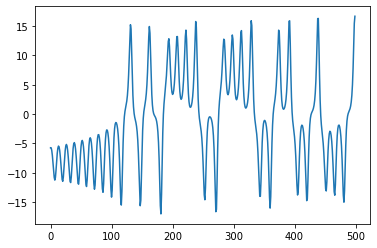

In [3]:
# input_weight = 1e-1 #Input weight for reservoir
input_weight = 1e-2 #Input weight for reservoir
spectral_radius = 0.9 #Spectral radius, maximum magnitude eigenvalue of reservoir adjacency matrix 
regularization = 1e-5 #Tikhonov regularization term
average_degree = 3 #Average in-degree for each reservoir node
leakage = 0 #Leakage parameter, unused
# forget = 1
# inv_forget = 1/forget
data_seed = 30  #Seed for initializing data

int_step = 0.01
step = 0.05
#Time step size for Lorenz system
transient_length = int(50/step) #Length of initial transient input to reservoir before training begins
data_length = int(3000/int_step) #Length of full data set
train_length = int(150/step) #Length of training data
predict_length = 200  #Length of each prediction
predict_gap_length = int(5/step) #Length of time between subsequent predictions
num_predictions = 100  #Total number of predictions made

approx_num_nodes = 300 #Approximate Number of nodes in the reservoir (rounded such that each input connects to the same number of nodes)
np.random.seed(data_seed)
train_input_sequence = getLorenzData(data_length,r_t_const,dxdt_lorenz,tau = int_step,sample_tau = step) #Obtain Lorenz Data
# scaler = preprocessing.StandardScaler().fit(train_input_sequence.T)
# train_input_sequence = np.transpose(scaler.transform(train_input_sequence.T))


## Randomly generate reservoit adjacency and input matrices and initialize the reservoir node states.

In [4]:
input_size = train_input_sequence.shape[0]
num_nodes = int(np.ceil(approx_num_nodes/input_size)*input_size); #Calculate number of nodes

# Create the adjacency matrix and set the spectral radius
A_mat = sparse.random(num_nodes,num_nodes, density = average_degree/num_nodes)
eg = linalg.eigs(A_mat, k = 1, return_eigenvectors=False)
A_mat = spectral_radius/np.abs(eg[0])*A_mat
A_mat = np.loadtxt('testA.csv',delimiter = ',')

# Set the adjacency matrix such that all inputs go to the same number of nodes
q = int(np.floor(num_nodes/(input_size)))
win = np.zeros((num_nodes,input_size))
for i in range(input_size):
    np.random.seed(i)
    ip = (-1 + 2*np.random.randn(q));
    win[i*q:(i+1)*q,i] = input_weight*ip;
    
win = np.loadtxt('testWin.csv',delimiter = ',')
    
#Initialize reservoir state vector x and states array
x = np.zeros(num_nodes)
states = np.zeros((num_nodes, train_length))

## After an initial transient, record reservoir states and use them to calculate the output matrix.

In [5]:
# Advance reservoir state
for t in range(transient_length):
    x = advanceReservoir(win,A_mat,x,train_input_sequence[:,t],leakage)
    if t == 999:
        print(x[:5])
    
#Begin recording states for training
states[:,0] = x;

for t in range(train_length-1):
    states[:,t+1] = advanceReservoir(win,A_mat,states[:,t],train_input_sequence[:,t+transient_length],leakage)
    if t + transient_length == train_length - 2 + transient_length:
        print(t+transient_length)
        print(states[:5,t+1])
    
# print(states[:5,-1])
x = states[:,-1]

# We augment the reservoir states by squaring some of them to break the odd
# symmetry of the tanh function. We find experimentally that this improves
# performance for some systems.
aug_states = np.copy(states)
aug_states[::2,:] = np.power(states[::2,:],2)
idenmat = regularization*sparse.identity(num_nodes)
data_trstates = np.matmul(train_input_sequence[:,transient_length:transient_length+train_length],np.transpose(aug_states))
states_trstates = np.matmul(aug_states,np.transpose(aug_states))
states_trstates_inv = pinv(states_trstates + idenmat)
wout = np.matmul(data_trstates,states_trstates_inv)
norm_error = np.sqrt(np.mean(train_input_sequence**2))
print(norm_error)
training_error = (wout @ aug_states) - train_input_sequence[:,transient_length:transient_length+train_length]
training_nrms_error = np.sqrt(np.mean(training_error**2))/norm_error
print(training_nrms_error)

[ 0.15058724 -0.6559309  -0.37663168 -0.75683616 -0.79959589]
3998
[-0.13082916 -0.17420006  0.03727721 -0.26894273 -0.73048221]
16.05761462594409
8.169978818854559e-05


## We evaluate the reservoir's performance over a set of prediction periods beginning right after training ends (this is not necessary, but is easiest). We then display the valid prediction times.

In [6]:
# Initialize data matrices
error_cutoff = 0.2;
predictions = np.zeros((input_size,predict_length,num_predictions))
errors = np.zeros((predict_length,num_predictions))
valid_times = np.zeros(num_predictions)
final_diff = np.zeros((input_size,num_predictions))


for pred in range(num_predictions):
    # Obtain the prediction
    predictions[:,:,pred] = getPrediction(win,A_mat,wout,x,predict_length,leakage)
    start_pred_idx = transient_length + train_length + pred*predict_gap_length - 1
    
    # Compare prediction to true system and calculate valid prediction time given the normalized RMS error cutoff
    truth = train_input_sequence[:,start_pred_idx:start_pred_idx + predict_length]
    final_diff[:,pred] = predictions[:,-1,pred] - truth[:,-1]
    errors[:,pred] = np.sqrt(np.mean((predictions[:,:,pred] - truth)**2,axis = 0))/norm_error
    for i in range(predict_length):
        if errors[i,pred] > error_cutoff:
            break
        else:
            valid_times[pred] += 1
    
    # Advance the reservoir node state to the next prediction
    for i in range(predict_gap_length):
        x = advanceReservoir(win,A_mat,x,train_input_sequence[:,start_pred_idx + i],leakage)
    
print(step*valid_times)

[ 4.1   6.3   4.35  8.15  3.45  2.9   6.05  5.6   4.6   8.    3.1   9.15
  5.    5.95  6.45  5.1   6.1   6.5   8.5   5.8   1.15  3.8   5.95  7.95
  6.65  6.1   4.4   7.4   5.65  3.15  4.    9.3   5.85  3.4   6.2   5.75
  5.5   6.65  6.25  5.8   1.25  5.2   6.05  5.7   5.3   2.25  7.15  5.95
  4.9   3.05  5.85  6.15  5.8   6.35  5.25  4.9   5.8   4.75  7.8   7.35
  5.5   7.85  3.15  4.05  6.15  6.45  6.75  6.1   6.45  3.25  5.45  7.05
  5.8   4.05  5.35  6.45  6.    4.9   9.2   4.35  4.75  7.25  9.2   6.75
  5.45  5.7   6.8   6.95  5.    6.1   4.3  10.    5.55  5.5   4.55  9.15
  5.05  6.1   5.35  6.6 ]


In [7]:
print(np.mean(step*valid_times))

5.732500000000001


## Plot an example prediction

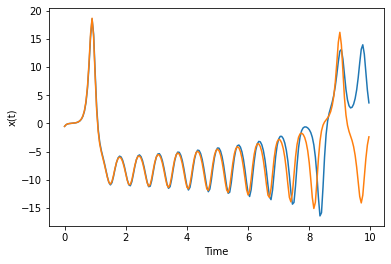

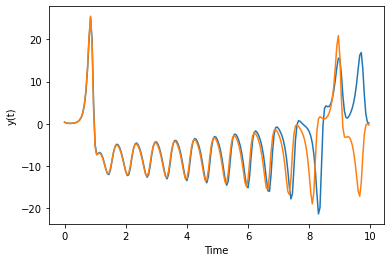

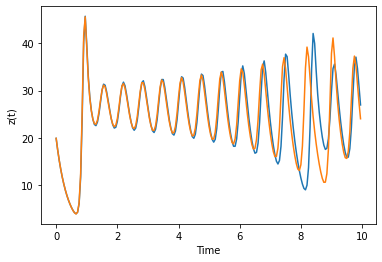

In [8]:
times = np.arange(0,step*predict_length,step)
plt.plot(times, truth[0,:],label = 'Truth')
plt.plot(times, predictions[0,:,-1],label = 'Prediction')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.show()

plt.plot(times, truth[1,:],label = 'Truth')
plt.plot(times, predictions[1,:,-1],label = 'Prediction')
plt.xlabel('Time')
plt.ylabel('y(t)')
plt.show()

plt.plot(times, truth[2,:],label = 'Truth')
plt.plot(times, predictions[2,:,-1],label = 'Prediction')
plt.xlabel('Time')
plt.ylabel('z(t)')
plt.show()